In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas import Series
from datetime import datetime
import numpy as np

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
flights = pd.read_csv('departed_predictive_clean.csv')

C:\Users\MeghanRoffler\AppData\Local\Temp\ipykernel_10856\963386781.py:1: DtypeWarning: Columns (28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('departed_predictive_clean.csv')


In [5]:
flights.head()
# Departure_delay15 is what we are tryin to predict 

,year,month,day_of_month,day_of_week,flight_date,airline_code,common_airline_code,origin,city_name,state_abbr,state_name,dest,dest_city_name,dest_state_abr,dest_state_name,scheduled_departure_time,departure_delay,dep_time_blk,scheduled_arrival_time,arr_time_blk,scheduled_elapsed_time,distance,distance_group,weather_delay,origin_takeoff_weather Type,origin_takeoff_weather Severity,origin_takeoff_weather StartTime(UTC),origin_takeoff_weather Precipitation(in),dest_takeoff_weather Type,dest_takeoff_weather Severity,dest_takeoff_weather StartTime(UTC),dest_takeoff_weather Precipitation(in),dep_delay15
0,2021,4,1,4,4/1/2021,UA,OO,DEN,"Denver, CO",CO,Colorado,ATY,"Watertown, SD",SD,South Dakota,2021-04-01T17:05:00.000Z,4.0,1000-1059,2021-04-01T18:47:00.000Z,1200-1259,102.0,519.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2021,4,2,5,4/2/2021,UA,OO,DEN,"Denver, CO",CO,Colorado,ATY,"Watertown, SD",SD,South Dakota,2021-04-02T17:05:00.000Z,-6.0,1000-1059,2021-04-02T18:47:00.000Z,1200-1259,102.0,519.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2021,4,3,6,4/3/2021,UA,OO,DEN,"Denver, CO",CO,Colorado,ATY,"Watertown, SD",SD,South Dakota,2021-04-03T19:05:00.000Z,-8.0,1200-1259,2021-04-03T20:47:00.000Z,1400-1459,102.0,519.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2021,4,4,7,4/4/2021,UA,OO,DEN,"Denver, CO",CO,Colorado,ATY,"Watertown, SD",SD,South Dakota,2021-04-04T17:05:00.000Z,-6.0,1000-1059,2021-04-04T18:47:00.000Z,1200-1259,102.0,519.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2021,4,5,1,4/5/2021,UA,OO,DEN,"Denver, CO",CO,Colorado,ATY,"Watertown, SD",SD,South Dakota,2021-04-05T17:05:00.000Z,-10.0,1000-1059,2021-04-05T18:47:00.000Z,1200-1259,102.0,519.0,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
conditions_depdelay15 = [
    (flights['departure_delay'] < 15), (flights['departure_delay'] >= 15) 
    ]


# create a list of the values we want to assign for each condition
values = [0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
flights['dep_delay15'] = np.select(conditions_depdelay15, values)

# ------------------------------------------ Initial Cleaning ------------------------------------------

In [7]:
# changing columns to datetimes 

flights["scheduled_arrival_time"] = pd.to_datetime(flights["scheduled_arrival_time"])
flights["scheduled_departure_time"] = pd.to_datetime(flights["scheduled_departure_time"])
flights["origin_takeoff_weather StartTime(UTC)"] = pd.to_datetime(flights["origin_takeoff_weather StartTime(UTC)"])
flights["dest_takeoff_weather StartTime(UTC)"] = pd.to_datetime(flights["dest_takeoff_weather StartTime(UTC)"])


# removing departure delay column
flights = flights.drop(columns = ['departure_delay'])

flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6190358 entries, 0 to 6190357
Data columns (total 32 columns):
 #   Column                                    Dtype              
---  ------                                    -----              
 0   year                                      int64              
 1   month                                     int64              
 2   day_of_month                              int64              
 3   day_of_week                               int64              
 4   flight_date                               object             
 5   airline_code                              object             
 6   common_airline_code                       object             
 7   origin                                    object             
 8   city_name                                 object             
 9   state_abbr                                object             
 10  state_name                                object             
 11  dest       

In [8]:
# creating new calculated columns 

flights["dep_weatherstart_minutes"] = flights["scheduled_departure_time"] - flights["origin_takeoff_weather StartTime(UTC)"]
flights["arr_weatherstart_minutes"] = flights["scheduled_arrival_time"] - flights["dest_takeoff_weather StartTime(UTC)"]

In [9]:
# converting columns from timedelta to minutes 

flights["dep_weatherstart_minutes"] = flights["dep_weatherstart_minutes"] / np.timedelta64(1, 'm')
flights["arr_weatherstart_minutes"] = flights["arr_weatherstart_minutes"] / np.timedelta64(1, 'm')


In [10]:
## dealing with nulls 

# replacing nan weather with "none"
flights["origin_takeoff_weather Type"].replace(np.nan, 'None', inplace = True)
flights["dest_takeoff_weather Type"].replace(np.nan, 'None', inplace = True)

# replacing nan weather severity with "none"
flights["origin_takeoff_weather Severity"].replace(np.nan, 'None', inplace = True)
flights["dest_takeoff_weather Severity"].replace(np.nan, 'None', inplace = True)

In [11]:
## deleting columns 

flights = flights.drop(columns = ['year', 'flight_date', 'day_of_month', 'city_name', 'state_abbr', 'state_name', 'dest_city_name', 'dest_state_abr', 'dest_state_name', 'scheduled_departure_time', 'scheduled_arrival_time'])

In [12]:
## restructuring time block columns

conditions_dep = [
    ((flights['dep_time_blk'] == '0600-0659') | (flights['dep_time_blk'] == '0700-0759') | (flights['dep_time_blk'] == '0800-0859') | (flights['dep_time_blk'] == '0900-0959') | (flights['dep_time_blk'] == '1000-1059') | (flights['dep_time_blk'] == '1100-1159')),
    ((flights['dep_time_blk'] == '1200-1259') | (flights['dep_time_blk'] == '1300-1359') | (flights['dep_time_blk'] == '1400-1459') | (flights['dep_time_blk'] == '1500-1559') | (flights['dep_time_blk'] == '1600-1659') | (flights['dep_time_blk'] == '1700-1759')),
    ((flights['dep_time_blk'] == '1800-1859') | (flights['dep_time_blk'] == '1900-1959') | (flights['dep_time_blk'] == '2000-2059') | (flights['dep_time_blk'] == '2100-2159')),
    ((flights['dep_time_blk'] == '2200-2259') | (flights['dep_time_blk'] == '2300-2359') | (flights['dep_time_blk'] == '0001-0559'))
    ]

conditions_arr = [
    ((flights['arr_time_blk'] == '0600-0659') | (flights['arr_time_blk'] == '0700-0759') | (flights['arr_time_blk'] == '0800-0859') | (flights['arr_time_blk'] == '0900-0959') | (flights['arr_time_blk'] == '1000-1059') | (flights['arr_time_blk'] == '1100-1159')),
    ((flights['arr_time_blk'] == '1200-1259') | (flights['arr_time_blk'] == '1300-1359') | (flights['arr_time_blk'] == '1400-1459') | (flights['arr_time_blk'] == '1500-1559') | (flights['arr_time_blk'] == '1600-1659') | (flights['arr_time_blk'] == '1700-1759')),
    ((flights['arr_time_blk'] == '1800-1859') | (flights['arr_time_blk'] == '1900-1959') | (flights['arr_time_blk'] == '2000-2059') | (flights['arr_time_blk'] == '2100-2159')),
    ((flights['arr_time_blk'] == '2200-2259') | (flights['arr_time_blk'] == '2300-2359') | (flights['arr_time_blk'] == '0001-0559'))
    ]


# create a list of the values we want to assign for each condition
values = ['morning', 'afternoon', 'evening', 'night']

# create a new column and use np.select to assign values to it using our lists as arguments
flights['dep_time'] = np.select(conditions_dep, values)
flights['arr_time'] = np.select(conditions_arr, values)

# remove old time blk colimns 

flights = flights.drop(columns = ['arr_time_blk', 'dep_time_blk'])


In [13]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6190358 entries, 0 to 6190357
Data columns (total 23 columns):
 #   Column                                    Dtype              
---  ------                                    -----              
 0   month                                     int64              
 1   day_of_week                               int64              
 2   airline_code                              object             
 3   common_airline_code                       object             
 4   origin                                    object             
 5   dest                                      object             
 6   scheduled_elapsed_time                    float64            
 7   distance                                  float64            
 8   distance_group                            int64              
 9   weather_delay                             float64            
 10  origin_takeoff_weather Type               object             
 11  origin_take

In [14]:
## Heather's Suggested Edits: Reduce airlines and airports 

airports_to_keep = ["ATL","ORD","DFW","DEN","CLT","LAX","SEA","PHX","IAH","LAS"]
airlines_to_keep = ["AA", "DL", "WN", "UA"]


flights = flights[(flights["airline_code"] == 'AA') | (flights["airline_code"] == 'DL') | (flights["airline_code"] == 'WN') | (flights["airline_code"] == 'UA')]
flights = flights[(flights["origin"] == 'ATL') | (flights["dest"] == 'ATL') | (flights["origin"] == 'ORD') | (flights["dest"] == 'ORD') | (flights["origin"] == 'DFW') | (flights["dest"] == 'DFW') |
                 (flights["origin"] == 'DEN') | (flights["dest"] == 'DEN') | (flights["origin"] == 'CLT') | (flights["dest"] == 'CLT') | (flights["origin"] == 'LAX') | (flights["dest"] == 'LAX') |
                 (flights["origin"] == 'SEA') | (flights["dest"] == 'SEA') | (flights["origin"] == 'PHX') | (flights["dest"] == 'PHX') | (flights["origin"] == 'IAH') | (flights["dest"] == 'IAH') |
                 (flights["origin"] == 'LAS') | (flights["dest"] == 'LAS')]


In [15]:
flights["origin"].value_counts()


flights = flights[flights['origin'].map(flights['origin'].value_counts()) > 9999]
flights = flights[flights['dest'].map(flights['dest'].value_counts()) > 9999]

In [16]:
flights.shape

(2053088, 23)

In [17]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053088 entries, 39005 to 6170680
Data columns (total 23 columns):
 #   Column                                    Dtype              
---  ------                                    -----              
 0   month                                     int64              
 1   day_of_week                               int64              
 2   airline_code                              object             
 3   common_airline_code                       object             
 4   origin                                    object             
 5   dest                                      object             
 6   scheduled_elapsed_time                    float64            
 7   distance                                  float64            
 8   distance_group                            int64              
 9   weather_delay                             float64            
 10  origin_takeoff_weather Type               object             
 11  origin_

# ---------------------------------------- Creating 4 Datasets ----------------------------------------

In [18]:
## set 1: 
# dest_weather: none 
# origin_weather: none 

set1 = flights[(flights["origin_takeoff_weather Type"] == "None") & (flights["dest_takeoff_weather Type"] == "None")]
set1.shape

(1764387, 23)

In [19]:
## set 2: 
# dest_weather: none
# origin_weather: yes 

set2 = flights[(flights["origin_takeoff_weather Type"] != "None") & (flights["dest_takeoff_weather Type"] == "None")]
set2.shape

(136691, 23)

In [20]:
## set 3: 
# dest_weather: yes 
# origin_weather: none 

set3 = flights[(flights["origin_takeoff_weather Type"] == "None") & (flights["dest_takeoff_weather Type"] != "None")]
set3.shape

(133454, 23)

In [38]:
## set 4: 
# dest_weather: yes
# origin_weather: yes 

set4 = flights[(flights["origin_takeoff_weather Type"] != "None") & (flights["dest_takeoff_weather Type"] != "None")]
set4.shape

(18556, 23)

# ------------------------------------------ Set 1 ------------------------------------------

In [22]:
## TESTING OUT - USING DISTANCE AND common_AIRLINE_CODE (PLAY AROUND WITH USING DISTANCE AND COMMON_AIRLINE_CODE INSTEAD)
set1 = set1.drop(columns=['airline_code', 'distance_group'])


# dropping columns 
set1 = set1.drop(columns=['origin_takeoff_weather Type', 'origin_takeoff_weather Severity', 'origin_takeoff_weather StartTime(UTC)', 'origin_takeoff_weather Precipitation(in)', 'dest_takeoff_weather Type', 'dest_takeoff_weather Severity', 'dest_takeoff_weather StartTime(UTC)', 'dest_takeoff_weather Precipitation(in)', 'dep_weatherstart_minutes', 'arr_weatherstart_minutes'])
set1.head()

,month,day_of_week,common_airline_code,origin,dest,scheduled_elapsed_time,distance,weather_delay,dep_delay15,dep_time,arr_time
39005,4,4,OO,IAH,DCA,183.0,1208.0,0.0,0,afternoon,evening
39006,4,4,UA,IAH,DCA,177.0,1208.0,0.0,0,afternoon,evening
39007,4,4,YV,IAH,DCA,182.0,1208.0,0.0,0,morning,afternoon
39008,4,5,OO,IAH,DCA,183.0,1208.0,0.0,0,afternoon,evening
39009,4,5,UA,IAH,DCA,173.0,1208.0,0.0,0,afternoon,evening


In [23]:
## creating dummy variables set
dummy_set1 = set1.copy()

dummy_set1 = pd.get_dummies(dummy_set1, columns = ['month','day_of_week', 'common_airline_code', 'origin', 'dest', 'dep_time', 'arr_time'], drop_first=True)
dummy_set1.head()


,scheduled_elapsed_time,distance,weather_delay,dep_delay15,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,common_airline_code_AA,common_airline_code_C5,common_airline_code_DL,common_airline_code_G7,common_airline_code_MQ,common_airline_code_OH,common_airline_code_OO,common_airline_code_PT,common_airline_code_UA,common_airline_code_WN,common_airline_code_YV,common_airline_code_YX,common_airline_code_ZW,origin_ATL,origin_AUS,origin_BHM,origin_BNA,origin_BOI,origin_BOS,origin_BWI,origin_CHS,origin_CLE,origin_CLT,origin_CMH,origin_CVG,origin_DAL,origin_DCA,origin_DEN,origin_DFW,origin_DTW,origin_ELP,origin_EWR,origin_FLL,origin_HOU,origin_IAD,origin_IAH,origin_IND,origin_JAX,origin_JFK,origin_LAS,origin_LAX,origin_LGA,origin_MCI,origin_MCO,origin_MDW,origin_MEM,origin_MIA,origin_MKE,origin_MSP,origin_MSY,origin_OKC,origin_OMA,origin_ORD,origin_PDX,origin_PHL,origin_PHX,origin_PIT,origin_RDU,origin_RNO,origin_RSW,origin_SAN,origin_SAT,origin_SDF,origin_SEA,origin_SFO,origin_SJC,origin_SLC,origin_SMF,origin_SNA,origin_STL,origin_TPA,origin_TUL,origin_TUS,origin_TYS,dest_ATL,dest_AUS,dest_BHM,dest_BNA,dest_BOI,dest_BOS,dest_BWI,dest_CHS,dest_CLE,dest_CLT,dest_CMH,dest_CVG,dest_DAL,dest_DCA,dest_DEN,dest_DFW,dest_DTW,dest_ELP,dest_EWR,dest_FLL,dest_HOU,dest_IAD,dest_IAH,dest_IND,dest_JAX,dest_JFK,dest_LAS,dest_LAX,dest_LGA,dest_MCI,dest_MCO,dest_MDW,dest_MEM,dest_MIA,dest_MKE,dest_MSP,dest_MSY,dest_OKC,dest_OMA,dest_ORD,dest_PDX,dest_PHL,dest_PHX,dest_PIT,dest_RDU,dest_RNO,dest_RSW,dest_SAN,dest_SAT,dest_SDF,dest_SEA,dest_SFO,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUL,dest_TUS,dest_TYS,dep_time_evening,dep_time_morning,dep_time_night,arr_time_evening,arr_time_morning,arr_time_night
39005,183.0,1208.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
39006,177.0,1208.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
39007,182.0,1208.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
39008,183.0,1208.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
39009,173.0,1208.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Set 1 Modeling

In [24]:
# Creating X and y
garbage = dummy_set1.pop('weather_delay')
y = dummy_set1.pop('dep_delay15')
X = dummy_set1


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, stratify=y, test_size=0.15, random_state=12
)


In [26]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train_s, y_train)

print("Accuracy Score: % f" %(rf.score(X_test_s,y_test)))

Accuracy Score:  0.797109


In [27]:
y_pred = rf.predict(X_test_s)

cm = confusion_matrix(y_test, y_pred)

features = pd.DataFrame({'feature':list(X.columns),'importance':rf.feature_importances_}).sort_values('importance',ascending=False)



top_features = features.head(10)

top_features

,feature,importance
0,scheduled_elapsed_time,0.222590
1,distance,0.062100
15,day_of_week_4,0.047032
16,day_of_week_5,0.045792
18,day_of_week_7,0.042318
17,day_of_week_6,0.039551
13,day_of_week_2,0.037488
14,day_of_week_3,0.036612
28,common_airline_code_WN,0.030222
155,dep_time_morning,0.019093


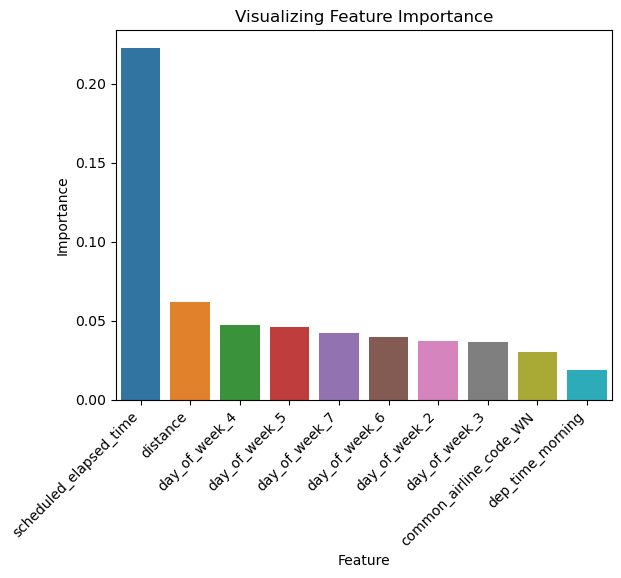

In [28]:
ax = sns.barplot(x = top_features.feature, y = top_features.importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Visualizing Feature Importance')
plt.xticks(rotation = 45,ha = 'right')
plt.show()

In [29]:
df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_pred))
df.index.name = 'Actual label'
df.columns.name = 'Predicted label'
df

Predicted label,0,1
Actual label,,
0,199428,19532
1,34165,11534


In [30]:
accuracy_score(y_test, y_pred)

0.7971087323688217

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, accuracy_score
gb = XGBClassifier()
gb.fit(X_train, y_train)
y_hat = gb.predict(X_test)
accuracy_score(y_test,y_hat)


MemoryError: Unable to allocate 1.79 GiB for an array with shape (160, 1499728) and data type float64

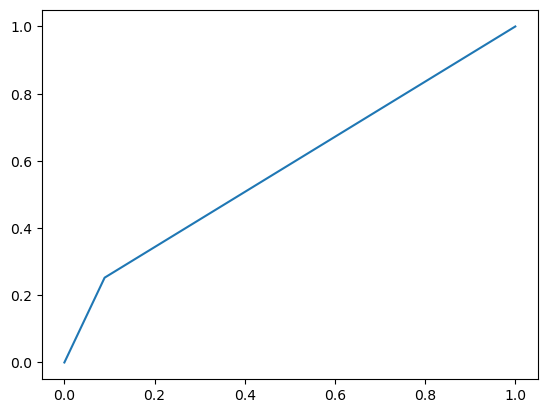

In [35]:
from sklearn.metrics import roc_curve 
curve = roc_curve(y_test, rf.predict(X_test_s))
plt.plot(curve[0], curve[1], label='ROC');


In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score

y_hat = rf.predict(X_test_s)
auc(curve[0],curve[1])



0.5815935678156705

# ------------------------------------------ Set 2 ------------------------------------------

In [76]:
## TESTING OUT - USING DISTANCE AND common AIRLINE_CODE (PLAY AROUND WITH USING DISTANCE AND COMMON_AIRLINE_CODE INSTEAD)
set2 = set2.drop(columns=['airline_code', 'distance_group'])


# dropping columns 
set2 = set2.drop(columns=['origin_takeoff_weather StartTime(UTC)', 'dest_takeoff_weather Type', 'dest_takeoff_weather Severity', 'dest_takeoff_weather StartTime(UTC)', 'dest_takeoff_weather Precipitation(in)', 'arr_weatherstart_minutes'])
set2.head()

,month,day_of_week,common_airline_code,origin,dest,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Type,origin_takeoff_weather Precipitation(in),dep_delay15,dep_weatherstart_minutes,dep_time,arr_time
39020,4,2,OO,IAH,DCA,183.0,1208.0,0.0,Rain,0.00,0,37.0,afternoon,evening
39043,4,2,YV,IAH,DCA,182.0,1208.0,0.0,Rain,0.00,0,22.0,morning,afternoon
39046,4,3,YV,IAH,DCA,182.0,1208.0,0.0,Rain,0.11,0,48.0,morning,afternoon
39050,4,5,OO,IAH,DCA,183.0,1208.0,0.0,Rain,0.00,0,37.0,afternoon,evening
39051,4,5,UA,IAH,DCA,173.0,1208.0,0.0,Fog,0.00,0,35.0,afternoon,evening


In [77]:
## creating dummy variables

dummy_set2 = set2.copy()

dummy_set2 = pd.get_dummies(dummy_set2, columns = ['month','day_of_week', 'common_airline_code', 'origin', 'dest', 'dep_time', 'arr_time', 'origin_takeoff_weather Type', 'origin_takeoff_weather Severity'], drop_first=True)
dummy_set2.head()


,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Precipitation(in),dep_delay15,dep_weatherstart_minutes,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,common_airline_code_AA,common_airline_code_C5,common_airline_code_DL,common_airline_code_G7,common_airline_code_MQ,common_airline_code_OH,common_airline_code_OO,common_airline_code_PT,common_airline_code_UA,common_airline_code_WN,common_airline_code_YV,common_airline_code_YX,common_airline_code_ZW,origin_ATL,origin_AUS,origin_BHM,origin_BNA,origin_BOI,origin_BOS,origin_BWI,origin_CHS,origin_CLE,origin_CLT,origin_CMH,origin_CVG,origin_DAL,origin_DCA,origin_DEN,origin_DFW,origin_DTW,origin_ELP,origin_EWR,origin_FLL,origin_HOU,origin_IAD,origin_IAH,origin_IND,origin_JAX,origin_JFK,origin_LAS,origin_LAX,origin_LGA,origin_MCI,origin_MCO,origin_MDW,origin_MEM,origin_MIA,origin_MKE,origin_MSP,origin_MSY,origin_OKC,origin_OMA,origin_ORD,origin_PDX,origin_PHL,origin_PHX,origin_PIT,origin_RDU,origin_RNO,origin_RSW,origin_SAN,origin_SAT,origin_SDF,origin_SEA,origin_SFO,origin_SJC,origin_SLC,origin_SMF,origin_SNA,origin_STL,origin_TPA,origin_TUL,origin_TUS,origin_TYS,dest_ATL,dest_AUS,dest_BHM,dest_BNA,dest_BOI,dest_BOS,dest_BWI,dest_CHS,dest_CLE,dest_CLT,dest_CMH,dest_CVG,dest_DAL,dest_DCA,dest_DEN,dest_DFW,dest_DTW,dest_ELP,dest_EWR,dest_FLL,dest_HOU,dest_IAD,dest_IAH,dest_IND,dest_JAX,dest_JFK,dest_LAS,dest_LAX,dest_LGA,dest_MCI,dest_MCO,dest_MDW,dest_MEM,dest_MIA,dest_MKE,dest_MSP,dest_MSY,dest_OKC,dest_OMA,dest_ORD,dest_PDX,dest_PHL,dest_PHX,dest_PIT,dest_RDU,dest_RNO,dest_RSW,dest_SAN,dest_SAT,dest_SDF,dest_SEA,dest_SFO,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUL,dest_TUS,dest_TYS,dep_time_evening,dep_time_morning,dep_time_night,arr_time_evening,arr_time_morning,arr_time_night,origin_takeoff_weather Type_Fog,origin_takeoff_weather Type_Hail,origin_takeoff_weather Type_Precipitation,origin_takeoff_weather Type_Rain,origin_takeoff_weather Type_Snow,origin_takeoff_weather Type_Storm
39020,183.0,1208.0,0.0,0.00,0,37.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
39043,182.0,1208.0,0.0,0.00,0,22.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
39046,182.0,1208.0,0.0,0.11,0,48.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
39050,183.0,1208.0,0.0,0.00,0,37.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
39051,173.0,1208.0,0.0,0.00,0,35.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


### Set 2 Modeling

In [78]:
# Creating X and y
garbage = dummy_set2.pop('weather_delay')
y = dummy_set2.pop('dep_delay15')
X = dummy_set2

X_train, X_test, y_train, y_test = train_test_split(
    X,y, stratify=y, test_size=0.15, random_state=12
)


scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train_s, y_train)

print("Accuracy Score: % f" %(rf.score(X_test_s,y_test)))

Linear Regression Score:  0.810086


In [53]:

y_pred = rf.predict(X_test_s)

cm = confusion_matrix(y_test, y_pred)


features = pd.DataFrame({'feature':list(X.columns),'importance':rf.feature_importances_}).sort_values('importance',ascending=False)

top_features = features.head(10)

top_features

,feature,importance
3,dep_weatherstart_minutes,0.121671
0,scheduled_elapsed_time,0.097445
1,distance,0.073584
2,origin_takeoff_weather Precipitation(in),0.068392
157,dep_time_morning,0.021051
160,arr_time_morning,0.016296
30,common_airline_code_WN,0.015238
17,day_of_week_4,0.014746
20,day_of_week_7,0.014509
18,day_of_week_5,0.014440


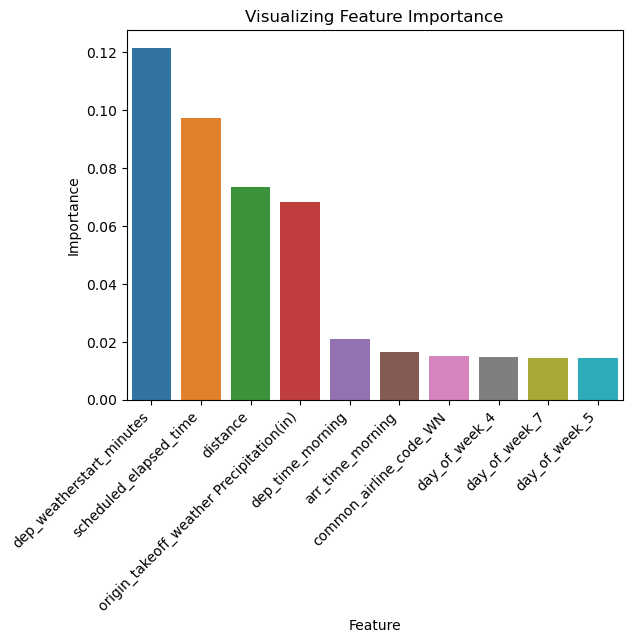

In [54]:
ax = sns.barplot(x = top_features.feature, y = top_features.importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Visualizing Feature Importance')
plt.xticks(rotation = 45,ha = 'right')
plt.show()

In [55]:
df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_pred))
df.index.name = 'Actual label'
df.columns.name = 'Predicted label'
df

Predicted label,0,1
Actual label,,
0,14963,803
1,3079,1659


C:\Users\MeghanRoffler\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


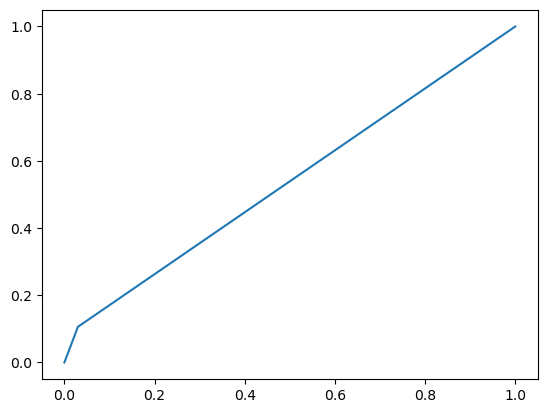

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, accuracy_score
gb = XGBClassifier()
gb.fit(X, y)
y_hat = gb.predict(X)
accuracy_score(y,y_hat)

from sklearn.metrics import roc_curve 
curve = roc_curve(y, rf.predict(X))
plt.plot(curve[0], curve[1], label='ROC');


# ------------------------------------------ Set 3 ------------------------------------------

In [50]:
# ## USING DISTANCE AND common AIRLINE_CODE (PLAY AROUND WITH USING DISTANCE AND COMMON_AIRLINE_CODE INSTEAD)
# set3 = set3.drop(columns=['airline_code', 'distance_group'])
# set3.head()

# # dropping columns 
# set3 = set3.drop(columns=['origin_takeoff_weather Type', 'origin_takeoff_weather Severity', 'origin_takeoff_weather StartTime(UTC)', 'origin_takeoff_weather Precipitation(in)', 'dest_takeoff_weather StartTime(UTC)', 'dep_weatherstart_minutes'])
# set3.head()

# # windsorizing departure delay column  (a common range for winsorization is the mean +/- 3 standard deviations)
# maxdelay = (set3["departure_delay"].mean()) + (3 * (set3["departure_delay"].std()))
# mindelay = (set3["departure_delay"].mean()) - (3 * (set3["departure_delay"].std()))

# print(maxdelay)
# print(mindelay)

# set3["departure_delay"].describe()

# # replace dep_delay outliers with maxdelay value 
# set3["departure_delay"] = np.where(set3["departure_delay"] > maxdelay, maxdelay, set3["departure_delay"])

178.02246348343544
-152.7149268041302


In [52]:
# ## creating dummy variables

# dummy_set3 = set3.copy()

# dummy_set3 = pd.get_dummies(dummy_set3, columns = ['month','day_of_week', 'common_airline_code', 'origin', 'dest', 'dep_time', 'arr_time', 'dest_takeoff_weather Type', 'dest_takeoff_weather Severity'], drop_first=True)
# dummy_set3.head()


,departure_delay,scheduled_elapsed_time,distance,weather_delay,dest_takeoff_weather Precipitation(in),arr_weatherstart_minutes,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,common_airline_code_AA,common_airline_code_C5,common_airline_code_DL,common_airline_code_G7,common_airline_code_MQ,common_airline_code_OH,common_airline_code_OO,common_airline_code_PT,common_airline_code_UA,common_airline_code_WN,common_airline_code_YV,common_airline_code_YX,common_airline_code_ZW,origin_ATL,origin_AUS,origin_BHM,origin_BNA,origin_BOI,origin_BOS,origin_BWI,origin_CHS,origin_CLE,origin_CLT,origin_CMH,origin_CVG,origin_DAL,origin_DCA,origin_DEN,origin_DFW,origin_DTW,origin_ELP,origin_EWR,origin_FLL,origin_HOU,origin_IAD,origin_IAH,origin_IND,origin_JAX,origin_JFK,origin_LAS,origin_LAX,origin_LGA,origin_MCI,origin_MCO,origin_MDW,origin_MEM,origin_MIA,origin_MKE,origin_MSP,origin_MSY,origin_OKC,origin_OMA,origin_ORD,origin_PDX,origin_PHL,origin_PHX,origin_PIT,origin_RDU,origin_RNO,origin_RSW,origin_SAN,origin_SAT,origin_SDF,origin_SEA,origin_SFO,origin_SJC,origin_SLC,origin_SMF,origin_SNA,origin_STL,origin_TPA,origin_TUL,origin_TUS,origin_TYS,dest_ATL,dest_AUS,dest_BHM,dest_BNA,dest_BOI,dest_BOS,dest_BWI,dest_CHS,dest_CLE,dest_CLT,dest_CMH,dest_CVG,dest_DAL,dest_DCA,dest_DEN,dest_DFW,dest_DTW,dest_ELP,dest_EWR,dest_FLL,dest_HOU,dest_IAD,dest_IAH,dest_IND,dest_JAX,dest_JFK,dest_LAS,dest_LAX,dest_LGA,dest_MCI,dest_MCO,dest_MDW,dest_MEM,dest_MIA,dest_MKE,dest_MSP,dest_MSY,dest_OKC,dest_OMA,dest_ORD,dest_PDX,dest_PHL,dest_PHX,dest_PIT,dest_RDU,dest_RNO,dest_RSW,dest_SAN,dest_SAT,dest_SDF,dest_SEA,dest_SFO,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUL,dest_TUS,dest_TYS,dep_time_evening,dep_time_morning,dep_time_night,arr_time_evening,arr_time_morning,arr_time_night,dest_takeoff_weather Type_Fog,dest_takeoff_weather Type_Hail,dest_takeoff_weather Type_Precipitation,dest_takeoff_weather Type_Rain,dest_takeoff_weather Type_Snow,dest_takeoff_weather Type_Storm,dest_takeoff_weather Severity_Light,dest_takeoff_weather Severity_Moderate,dest_takeoff_weather Severity_Other,dest_takeoff_weather Severity_Severe,dest_takeoff_weather Severity_UNK
39096,8.0,179.0,1208.0,0.0,0.39,227.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
39097,-4.0,180.0,1208.0,0.0,0.08,188.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
39098,-4.0,176.0,1208.0,0.0,0.07,182.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
39104,65.0,176.0,1208.0,0.0,0.04,363.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
39170,37.0,180.0,1208.0,0.0,0.01,188.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Set 3 Modeling 

In [53]:
# # Creating X and y
# garbage = dummy_set3.pop('weather_delay')
# y = dummy_set3.pop('departure_delay')
# X = dummy_set3

# X_train, X_test, y_train, y_test = train_test_split(
#     X,y, test_size=0.15, random_state=12
# )

# reg = LinearRegression().fit(X_train, y_train)
# reg.score(X_test,y_test)

0.12673241402578628

# ------------------------------------------ Set 4 ------------------------------------------

In [39]:
## USING DISTANCE AND common AIRLINE_CODE (PLAY AROUND WITH USING DISTANCE AND COMMON_AIRLINE_CODE INSTEAD)
set4 = set4.drop(columns=['airline_code', 'distance_group'])
set4.head()

# dropping columns 
set4 = set4.drop(columns=['origin_takeoff_weather StartTime(UTC)', 'dest_takeoff_weather StartTime(UTC)', 'dest_takeoff_weather Type', 'dest_takeoff_weather Severity', 'origin_takeoff_weather Severity'])
set4.head()

,month,day_of_week,common_airline_code,origin,dest,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Type,origin_takeoff_weather Precipitation(in),dest_takeoff_weather Precipitation(in),dep_delay15,dep_weatherstart_minutes,arr_weatherstart_minutes,dep_time,arr_time
39044,4,3,OO,IAH,DCA,183.0,1208.0,0.0,Fog,0.00,0.17,0,37.0,341.0,afternoon,evening
39045,4,3,UA,IAH,DCA,173.0,1208.0,0.0,Fog,0.00,0.17,0,22.0,496.0,afternoon,evening
39214,2,3,YV,IAH,DCA,179.0,1208.0,0.0,Fog,0.00,0.07,0,232.0,187.0,afternoon,evening
39215,2,4,YV,IAH,DCA,177.0,1208.0,0.0,Rain,0.03,0.00,1,82.0,215.0,morning,afternoon
39217,2,4,YV,IAH,DCA,178.0,1208.0,0.0,Rain,0.10,0.00,0,22.0,201.0,afternoon,evening


In [40]:
## creating dummy variables

dummy_set4 = set4.copy()

dummy_set4 = pd.get_dummies(dummy_set4, columns = ['month','day_of_week', 'common_airline_code', 'origin', 'dest', 'dep_time', 'arr_time', 'origin_takeoff_weather Type'], drop_first=True)
dummy_set4.head()


,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Precipitation(in),dest_takeoff_weather Precipitation(in),dep_delay15,dep_weatherstart_minutes,arr_weatherstart_minutes,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,common_airline_code_AA,common_airline_code_C5,common_airline_code_DL,common_airline_code_G7,common_airline_code_MQ,common_airline_code_OH,common_airline_code_OO,common_airline_code_PT,common_airline_code_UA,common_airline_code_WN,common_airline_code_YV,common_airline_code_YX,common_airline_code_ZW,origin_ATL,origin_AUS,origin_BHM,origin_BNA,origin_BOI,origin_BOS,origin_BWI,origin_CHS,origin_CLE,origin_CLT,origin_CMH,origin_CVG,origin_DAL,origin_DCA,origin_DEN,origin_DFW,origin_DTW,origin_ELP,origin_EWR,origin_FLL,origin_HOU,origin_IAD,origin_IAH,origin_IND,origin_JAX,origin_JFK,origin_LAS,origin_LAX,origin_LGA,origin_MCI,origin_MCO,origin_MDW,origin_MEM,origin_MIA,origin_MKE,origin_MSP,origin_MSY,origin_OKC,origin_OMA,origin_ORD,origin_PDX,origin_PHL,origin_PHX,origin_PIT,origin_RDU,origin_RNO,origin_RSW,origin_SAN,origin_SAT,origin_SDF,origin_SEA,origin_SFO,origin_SJC,origin_SLC,origin_SMF,origin_SNA,origin_STL,origin_TPA,origin_TUL,origin_TUS,origin_TYS,dest_ATL,dest_AUS,dest_BHM,dest_BNA,dest_BOI,dest_BOS,dest_BWI,dest_CHS,dest_CLE,dest_CLT,dest_CMH,dest_CVG,dest_DAL,dest_DCA,dest_DEN,dest_DFW,dest_DTW,dest_ELP,dest_EWR,dest_FLL,dest_HOU,dest_IAD,dest_IAH,dest_IND,dest_JAX,dest_JFK,dest_LAS,dest_LAX,dest_LGA,dest_MCI,dest_MCO,dest_MDW,dest_MEM,dest_MIA,dest_MKE,dest_MSP,dest_MSY,dest_OKC,dest_OMA,dest_ORD,dest_PDX,dest_PHL,dest_PHX,dest_PIT,dest_RDU,dest_RNO,dest_RSW,dest_SAN,dest_SAT,dest_SDF,dest_SEA,dest_SFO,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUL,dest_TUS,dest_TYS,dep_time_evening,dep_time_morning,dep_time_night,arr_time_evening,arr_time_morning,arr_time_night,origin_takeoff_weather Type_Fog,origin_takeoff_weather Type_Precipitation,origin_takeoff_weather Type_Rain,origin_takeoff_weather Type_Snow,origin_takeoff_weather Type_Storm
39044,183.0,1208.0,0.0,0.00,0.17,0,37.0,341.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
39045,173.0,1208.0,0.0,0.00,0.17,0,22.0,496.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
39214,179.0,1208.0,0.0,0.00,0.07,0,232.0,187.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
39215,177.0,1208.0,0.0,0.03,0.00,1,82.0,215.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
39217,178.0,1208.0,0.0,0.10,0.00,0,22.0,201.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Set 4 Modeling

In [41]:
# Creating X and y
garbage = dummy_set4.pop('weather_delay')
y = dummy_set4.pop('dep_delay15')
X = dummy_set4


X_train, X_test, y_train, y_test = train_test_split(
    X,y, stratify = y, test_size=0.15, random_state=12
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train_s, y_train)

print("Accuracy Score: % f" %(rf.score(X_test_s,y_test)))

Accuracy Score:  0.797773


In [42]:
y_pred = rf.predict(X_test_s)

cm = confusion_matrix(y_test, y_pred)

features = pd.DataFrame({'feature':list(X.columns),'importance':rf.feature_importances_}).sort_values('importance',ascending=False)



top_features = features.head(10)

top_features


,feature,importance
4,dep_weatherstart_minutes,0.091610
5,arr_weatherstart_minutes,0.090850
0,scheduled_elapsed_time,0.078702
1,distance,0.064405
2,origin_takeoff_weather Precipitation(in),0.056644
3,dest_takeoff_weather Precipitation(in),0.054747
159,dep_time_morning,0.016845
162,arr_time_morning,0.014420
16,month_12,0.012561
19,day_of_week_4,0.012470


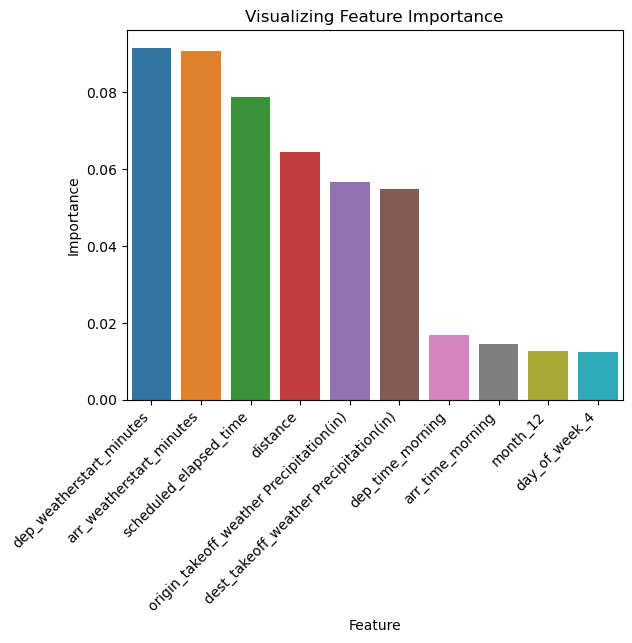

In [46]:
ax = sns.barplot(x = top_features.feature, y = top_features.importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Visualizing Feature Importance')
plt.xticks(rotation = 45,ha = 'right')
plt.show()

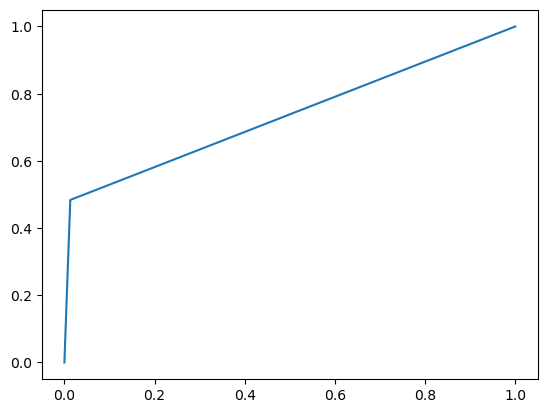

In [44]:
from sklearn.metrics import roc_curve 
curve = roc_curve(y, gb.predict(X))
plt.plot(curve[0], curve[1], label='ROC');


In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score

y_hat = rf.predict(X)
auc(curve[0],curve[1])

C:\Users\MeghanRoffler\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7353317175901337

## Set 4 playing

In [74]:
dummy_set44 = set4.copy()

dummy_set44 = dummy_set44.drop(columns=['dest_takeoff_weather Type', 'dest_takeoff_weather Severity', 'arr_weatherstart_minutes'])
dummy_set44.head()



,month,day_of_week,common_airline_code,origin,dest,departure_delay,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Type,origin_takeoff_weather Severity,origin_takeoff_weather Precipitation(in),dest_takeoff_weather Precipitation(in),dep_weatherstart_minutes,dep_time,arr_time
39044,4,3,OO,IAH,DCA,-6.0,183.0,1208.0,0.0,Fog,Moderate,0.00,0.17,37.0,afternoon,evening
39045,4,3,UA,IAH,DCA,-5.0,173.0,1208.0,0.0,Fog,Moderate,0.00,0.17,22.0,afternoon,evening
39214,2,3,YV,IAH,DCA,-5.0,179.0,1208.0,0.0,Fog,Severe,0.00,0.07,232.0,afternoon,evening
39215,2,4,YV,IAH,DCA,71.0,177.0,1208.0,0.0,Rain,Light,0.03,0.00,82.0,morning,afternoon
39217,2,4,YV,IAH,DCA,-7.0,178.0,1208.0,0.0,Rain,Moderate,0.10,0.00,22.0,afternoon,evening


In [75]:
dummy_set44 = pd.get_dummies(dummy_set44, columns = ['month','day_of_week', 'common_airline_code', 'origin', 'dest', 'dep_time', 'arr_time', 'origin_takeoff_weather Type', 'origin_takeoff_weather Severity'], drop_first=True)
dummy_set4.head()

,scheduled_elapsed_time,distance,weather_delay,origin_takeoff_weather Precipitation(in),dest_takeoff_weather Precipitation(in),dep_weatherstart_minutes,arr_weatherstart_minutes,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,common_airline_code_AA,common_airline_code_C5,common_airline_code_DL,common_airline_code_G7,common_airline_code_MQ,common_airline_code_OH,common_airline_code_OO,common_airline_code_PT,common_airline_code_UA,common_airline_code_WN,common_airline_code_YV,common_airline_code_YX,common_airline_code_ZW,origin_ATL,origin_AUS,origin_BHM,origin_BNA,origin_BOI,origin_BOS,origin_BWI,origin_CHS,origin_CLE,origin_CLT,origin_CMH,origin_CVG,origin_DAL,origin_DCA,origin_DEN,origin_DFW,origin_DTW,origin_ELP,origin_EWR,origin_FLL,origin_HOU,origin_IAD,origin_IAH,origin_IND,origin_JAX,origin_JFK,origin_LAS,origin_LAX,origin_LGA,origin_MCI,origin_MCO,origin_MDW,origin_MEM,origin_MIA,origin_MKE,origin_MSP,origin_MSY,origin_OKC,origin_OMA,origin_ORD,origin_PDX,origin_PHL,origin_PHX,origin_PIT,origin_RDU,origin_RNO,origin_RSW,origin_SAN,origin_SAT,origin_SDF,origin_SEA,origin_SFO,origin_SJC,origin_SLC,origin_SMF,origin_SNA,origin_STL,origin_TPA,origin_TUL,origin_TUS,origin_TYS,dest_ATL,dest_AUS,dest_BHM,dest_BNA,dest_BOI,dest_BOS,dest_BWI,dest_CHS,dest_CLE,dest_CLT,dest_CMH,dest_CVG,dest_DAL,dest_DCA,dest_DEN,dest_DFW,dest_DTW,dest_ELP,dest_EWR,dest_FLL,dest_HOU,dest_IAD,dest_IAH,dest_IND,dest_JAX,dest_JFK,dest_LAS,dest_LAX,dest_LGA,dest_MCI,dest_MCO,dest_MDW,dest_MEM,dest_MIA,dest_MKE,dest_MSP,dest_MSY,dest_OKC,dest_OMA,dest_ORD,dest_PDX,dest_PHL,dest_PHX,dest_PIT,dest_RDU,dest_RNO,dest_RSW,dest_SAN,dest_SAT,dest_SDF,dest_SEA,dest_SFO,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUL,dest_TUS,dest_TYS,dep_time_evening,dep_time_morning,dep_time_night,arr_time_evening,arr_time_morning,arr_time_night,origin_takeoff_weather Type_Fog,origin_takeoff_weather Type_Precipitation,origin_takeoff_weather Type_Rain,origin_takeoff_weather Type_Snow,origin_takeoff_weather Type_Storm,origin_takeoff_weather Severity_Light,origin_takeoff_weather Severity_Moderate,origin_takeoff_weather Severity_Severe,origin_takeoff_weather Severity_UNK,dest_takeoff_weather Type_Fog,dest_takeoff_weather Type_Precipitation,dest_takeoff_weather Type_Rain,dest_takeoff_weather Type_Snow,dest_takeoff_weather Type_Storm,dest_takeoff_weather Severity_Light,dest_takeoff_weather Severity_Moderate,dest_takeoff_weather Severity_Severe,dest_takeoff_weather Severity_UNK
39044,183.0,1208.0,0.0,0.00,0.17,37.0,341.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
39045,173.0,1208.0,0.0,0.00,0.17,22.0,496.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
39214,179.0,1208.0,0.0,0.00,0.07,232.0,187.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
39215,177.0,1208.0,0.0,0.03,0.00,82.0,215.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<Figure size 400x2500 with 0 Axes>

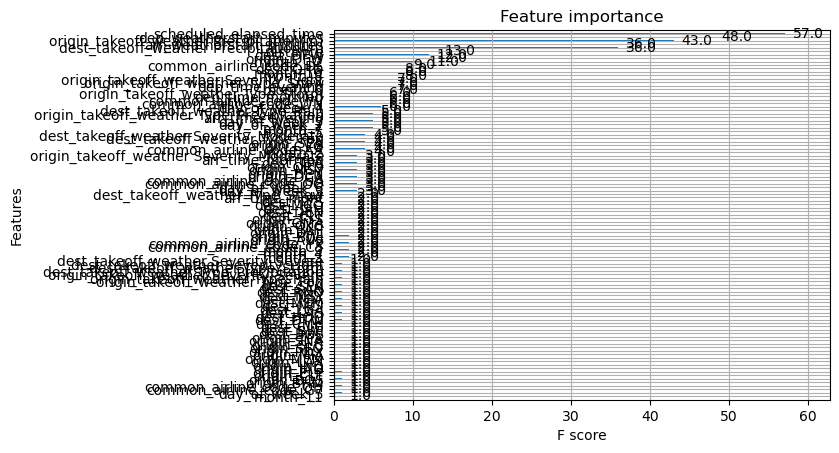

In [125]:
from xgboost import plot_importance
from matplotlib import pyplot


f = plt.figure()
f.set_figwidth(4)
f.set_figheight(25)

plot_importance(xgb_r)
pyplot.show()